In [1]:
import torch
import torchvision
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torch import nn
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
import pandas as pd

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
torch.manual_seed(42)
device = 'cuda'

In [3]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

In [4]:
dataset = torchvision.datasets.ImageFolder('data', transform=transform)
artists = dataset.classes

TRAIN_SIZE = int(0.7 * len(dataset))
VAL_SIZE = int(0.15 * len(dataset))
TEST_SIZE = len(dataset) - TRAIN_SIZE - VAL_SIZE

train_dataset, val_dataset, test_dataset = random_split(dataset, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

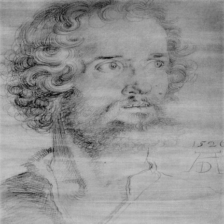

In [5]:
transforms.ToPILImage()(dataset[0][0])

In [6]:
print(dataset[0][1])
print(artists[dataset[0][1]])

0
Albrecht_Durer


In [7]:
LABELS = 50
model = torchvision.models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=LABELS)
model.to(device)

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
def show_batch(batch, rows, cols):
    figure = plt.figure(figsize=(12, 12))
    for i in range(rows * cols):
        img = batch[0][i]
        label = batch[1][i]
        figure.add_subplot(rows, cols, i + 1)
        plt.axis("off")
        plt.title(artists[label.item()])
        plt.imshow(img.permute(1, 2, 0))
    plt.show()

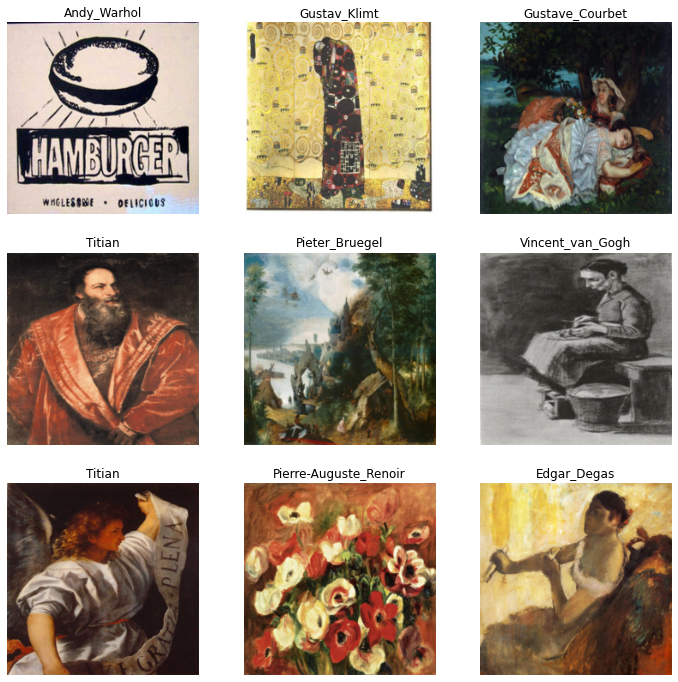

In [9]:
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=9, shuffle=True)

show_batch(next(iter(train_loader)), 3, 3)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
def get_logits(batch):
    imgs = batch[0].to(device)
    with torch.no_grad():
        logits = model(imgs)
    return logits

In [12]:
BATCH_SEG = 100

train_losses = []
val_losses = []

for epoch in range(6):
    print(f'Epoch {epoch}')
    running_loss = 0.0
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()

        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()
        if i % BATCH_SEG == BATCH_SEG - 1:
            print(f'Running loss: {running_loss / BATCH_SEG:.3f}')
            running_loss = 0
    train_loss /= len(train_loader)
    print(f'Training loss: {train_loss:.3f}')

    val_loss = 0.0
    for data in val_loader:
        logits = get_logits(data)
        labels = data[1].to(device)
        with torch.no_grad():
            loss = criterion(logits, labels)
        val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Validation loss: {val_loss:.3f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print('Done')

Epoch 0
Running loss: 3.665
Running loss: 3.532
Running loss: 3.364
Running loss: 3.105
Running loss: 2.996
Running loss: 2.896
Training loss: 3.229
Validation loss: 2.863
Epoch 1
Running loss: 2.631
Running loss: 2.642
Running loss: 2.611
Running loss: 2.554
Running loss: 2.496
Running loss: 2.518
Training loss: 2.566
Validation loss: 2.464
Epoch 2
Running loss: 2.164
Running loss: 2.255
Running loss: 2.215
Running loss: 2.236
Running loss: 2.226
Running loss: 2.180
Training loss: 2.197
Validation loss: 2.304
Epoch 3
Running loss: 1.881
Running loss: 1.982
Running loss: 1.950
Running loss: 1.833
Running loss: 1.933
Running loss: 1.781
Training loss: 1.902
Validation loss: 2.175
Epoch 4
Running loss: 1.657
Running loss: 1.620
Running loss: 1.533
Running loss: 1.651
Running loss: 1.478
Running loss: 1.610
Training loss: 1.581
Validation loss: 2.002
Epoch 5
Running loss: 1.280
Running loss: 1.250
Running loss: 1.307
Running loss: 1.180
Running loss: 1.265
Running loss: 1.289
Training los

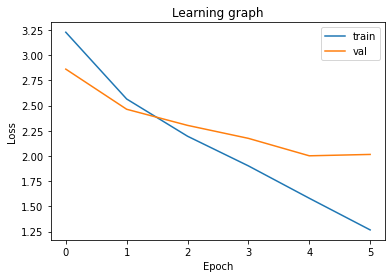

In [13]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='train')
ax.plot(val_losses, label='val')
ax.legend()
plt.title('Learning graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
model.eval()

heatmap = np.zeros((LABELS, LABELS))
test_loader = DataLoader(test_dataset, batch_size=9, shuffle=True)
order = [0] * LABELS

for data in test_loader:
    logits = get_logits(data)
    labels = data[1].to(device)
    preds = logits.argmax(axis=1)
    for i in range(labels.shape[0]):
        heatmap[labels[i].item()][preds[i].item()] += 1
        order[torch.sum(logits[i] > logits[i][labels[i].item()])] += 1

In [15]:
print(f'Average precision: {np.trace(heatmap) / np.sum(heatmap):.2%}')

Average precision: 45.93%


In [16]:
order_k = [3, 5, 10, 25]

for k in order_k:
    print(f'Top-k [k = {k}] prediction accuracy: {sum(order[:k]) / sum(order):.2%}')

Top-k [k = 3] prediction accuracy: 68.58%
Top-k [k = 5] prediction accuracy: 78.71%
Top-k [k = 10] prediction accuracy: 89.00%
Top-k [k = 25] prediction accuracy: 97.85%


In [17]:
def print_artist_data(arr, field_name):
    df = pd.DataFrame({'name': artists, field_name : arr})
    print(df.round(2))

In [18]:
print('Recall by artists:')
recall = np.diag(heatmap) / np.sum(heatmap, axis=1)
print_artist_data(recall, 'recall')

Recall by artists:
                         name  recall
0              Albrecht_Durer    0.75
1               Alfred_Sisley    0.90
2           Amedeo_Modigliani    0.54
3               Andrei_Rublev    0.62
4                 Andy_Warhol    0.33
5            Camille_Pissarro    0.00
6                  Caravaggio    0.44
7                Claude_Monet    0.00
8                Diego_Rivera    0.15
9             Diego_Velazquez    0.12
10                Edgar_Degas    0.77
11              Edouard_Manet    0.17
12               Edvard_Munch    0.00
13                   El_Greco    0.82
14           Eugene_Delacroix    0.00
15             Francisco_Goya    0.59
16                Frida_Kahlo    0.21
17             Georges_Seurat    0.18
18          Giotto_di_Bondone    0.72
19               Gustav_Klimt    0.29
20            Gustave_Courbet    0.00
21              Henri_Matisse    0.32
22             Henri_Rousseau    0.12
23  Henri_de_Toulouse-Lautrec    0.00
24           Hieronymus_Bosch  

<ipython-input-18-edc8288dde8c>:2: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(heatmap) / np.sum(heatmap, axis=1)


In [19]:
print('Precision by artists:')
prec = np.diag(heatmap) / np.sum(heatmap, axis=0)
print_artist_data(prec, 'precision')

Precision by artists:
                         name  precision
0              Albrecht_Durer       0.79
1               Alfred_Sisley       0.54
2           Amedeo_Modigliani       1.00
3               Andrei_Rublev       0.47
4                 Andy_Warhol       0.73
5            Camille_Pissarro       0.00
6                  Caravaggio       0.50
7                Claude_Monet        NaN
8                Diego_Rivera       0.30
9             Diego_Velazquez       1.00
10                Edgar_Degas       0.67
11              Edouard_Manet       0.60
12               Edvard_Munch       0.00
13                   El_Greco       0.24
14           Eugene_Delacroix        NaN
15             Francisco_Goya       0.39
16                Frida_Kahlo       0.83
17             Georges_Seurat       1.00
18          Giotto_di_Bondone       0.68
19               Gustav_Klimt       0.19
20            Gustave_Courbet        NaN
21              Henri_Matisse       0.38
22             Henri_Rousseau      

<ipython-input-19-4e58d5b47cb1>:2: RuntimeWarning: invalid value encountered in divide
  prec = np.diag(heatmap) / np.sum(heatmap, axis=0)


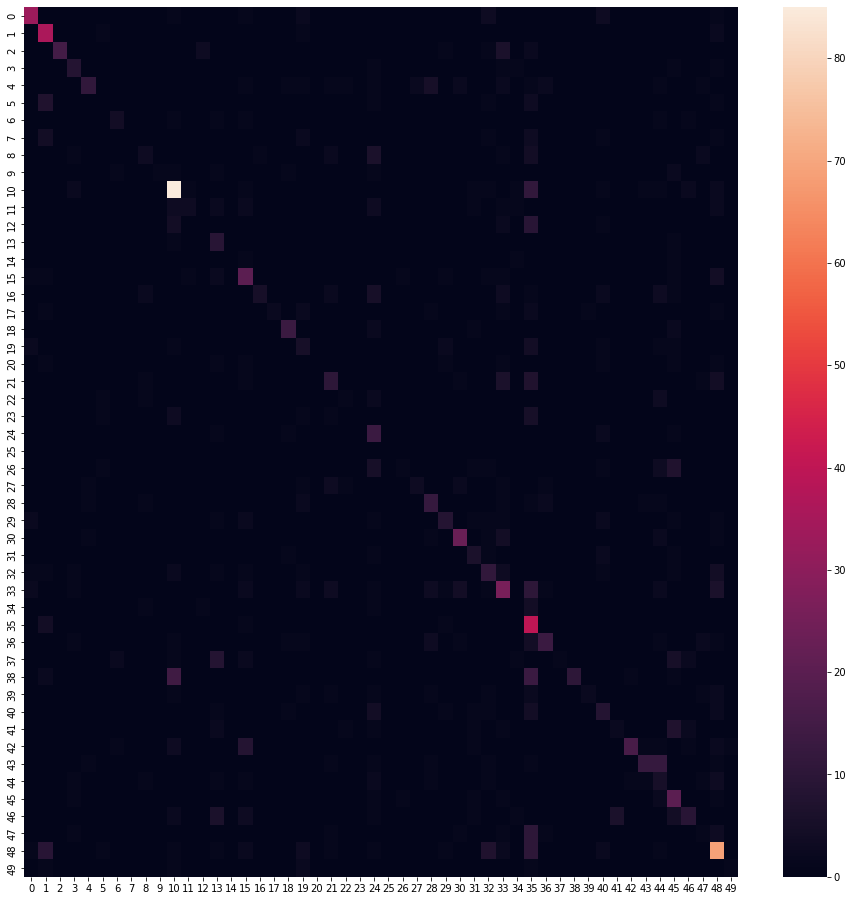

In [20]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(heatmap, ax=ax)
plt.show()